In [40]:
%load_ext autoreload
%autoreload 2

from charting import create_performance_chart
from llm_service import litellm_service, custom_llm_service
from utils import get_llm_answers, get_llm_stats, load_all_llm_answers_from_json, model_clean
from auto_eval import (
    create_all_llm_eval_messages, 
    extract_all_scores, 
    create_auto_eval_json, 
    get_llm_eval_responses, 
    score_multiple_choice_answers,
    validation_func,
    extract_valid_json,
)
from multiple_choice import construct_multiple_choice_question
from hotz_reflection import construct_hotz_reflection_question

from datetime import datetime
import pandas as pd
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Variables

In [22]:
answer_models = [
    "gpt-4-turbo-preview", 
    "gpt-4o",
    "meta.llama3-70b-instruct-v1:0", 
    "mistral/mistral-large-latest", 
    "mistral/open-mixtral-8x22b", 
    "claude-3-opus-20240229", 
    "vertex_ai/gemini-1.5-pro", 
    "vertex_ai/gemini-1.0-pro",
    "command-r", 
    "claude-3-5-sonnet-20240620",
]

answer_rounds = 10 # Number of rounds of questions to ask each model
answer_hyperparams = {
    'batch_size': 10, # Max number of questions to send to a model at once (10 is sensible)
    'temperature': 0, # 0 is default and the most deterministic
    'max_tokens': 2048, # 2048 works for most models, but may have to be reduced for some models
    'num_retries': 5, # Number of times to retry a question if it fails
}

auto_eval_rounds = 1 # Number of rounds of auto evaluation to run to then average the scores
auto_eval_model = "gpt-4o"
auto_eval_hyperparams= {
    'temperature': 0,
    'max_tokens': 2048,
    'batch_size': 30,
}

multiple_choice_questions = True
hotz_reflection = True
benchmark_name = 'Benchmark' if not multiple_choice_questions else 'Multi-Benchmark'
date_now = datetime.now().strftime('%Y-%m-%d') #'2024-06-10'
folder_name = "2024-06-21-Multi-Benchmark (temp=0)" #f"{date_now}-{benchmark_name}"
answers_save_path = f"./{folder_name}/llm_outputs"
answers_hotz_save_path = f"./{folder_name}/hotz_reflection"
auto_eval_save_path = f"./{folder_name}/auto_eval_outputs"
auto_eval_hotz_save_path = f"./{folder_name}/auto_eval_hotz_outputs"
stats_save_path = f"./{folder_name}/tables_and_charts"


execution_steps = [
    # "get_llm_answers",
    # "hotz_reflection",
    # "auto_evaluate_answers",
    "generate_statistics", 
]

## Run Benchmark

In [23]:
def calc_incomplete_llm_answers(all_llm_answers, auto_eval_save_path, sub_eval_folders, date_now):
    all_llm_evals = load_all_llm_answers_from_json(auto_eval_save_path,
        prefix_replace='auto_eval-', sub_folders=sub_eval_folders)
    skip_evals = set(all_llm_evals.keys() & set(all_llm_answers.keys()))
    print(f'Skipping existing LLM evals (in {date_now} folder):', skip_evals)
    incomplete_llm_answers = {model: value for model, value in all_llm_answers.items() 
                               if model_clean(model) not in skip_evals}
    return incomplete_llm_answers

3. GENERATING STATISTICS
Eval for path: ./2024-06-21-Multi-Benchmark (temp=0)/auto_eval_outputs
Calculating stats for claude-3-5-sonnet-20240620
Calculating stats for claude-3-opus-20240229
Calculating stats for command-r
Calculating stats for gemini-1_0-pro
Calculating stats for gemini-1_5-pro
Calculating stats for gpt-4-turbo-preview
Calculating stats for gpt-4o
Calculating stats for meta_llama3-70b-instruct-v1_0
Calculating stats for mistral-large-latest
Calculating stats for open-mixtral-8x22b
claude-3-5-sonnet-20240620 0
claude-3-opus-20240229 0
command-r 0
gemini-1_0-pro 2
gemini-1_5-pro 6
gpt-4-turbo-preview 0
gpt-4o 0
meta_llama3-70b-instruct-v1_0 2
mistral-large-latest 2
open-mixtral-8x22b 8


,mean_score,std_dev_score,z_interval_error,ci_lower,ci_upper,output_count,invalid_outputs
model,,,,,,,
claude-3-5-sonnet-20240620,49.666667,50.082429,5.667360,44.000000,55.333333,300.0,0.0
gpt-4o,44.000000,49.721633,5.626532,38.333333,49.666667,300.0,0.0
claude-3-opus-20240229,43.000000,49.590295,5.611670,37.333333,48.666667,300.0,0.0
gpt-4-turbo-preview,35.000000,47.776654,5.406437,29.666667,40.333333,300.0,0.0
gemini-1_5-pro,31.333333,46.462365,5.257712,26.333333,36.666667,300.0,6.0
open-mixtral-8x22b,31.333333,46.462365,5.257712,26.333333,36.666667,300.0,8.0
meta_llama3-70b-instruct-v1_0,29.333333,45.605061,5.160699,24.333333,34.666667,300.0,2.0
mistral-large-latest,28.666667,45.296004,5.125725,23.666667,33.666667,300.0,2.0
command-r,25.000000,43.373620,4.908187,20.333333,30.000000,300.0,0.0


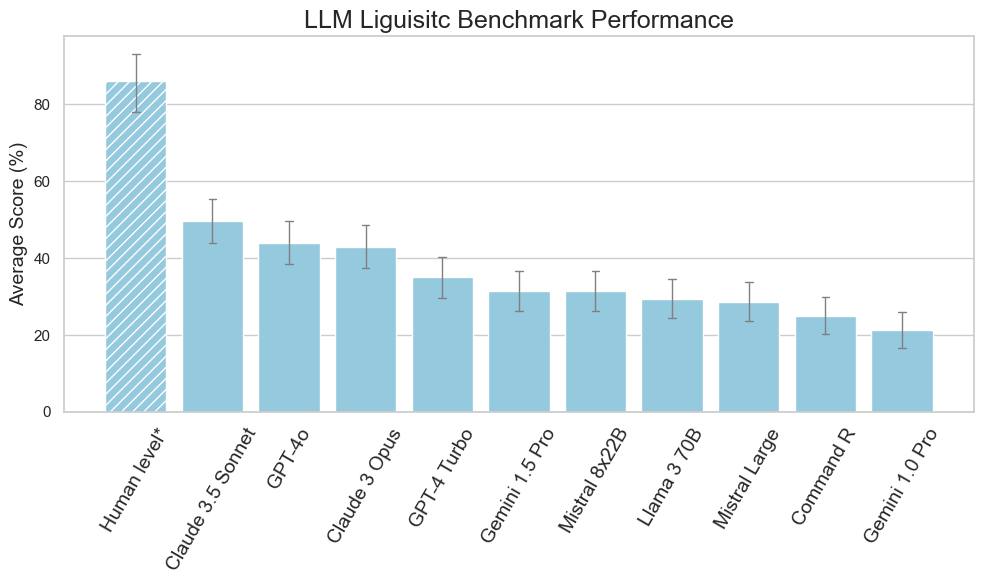

Eval for path: ./2024-06-21-Multi-Benchmark (temp=0)/auto_eval_hotz_outputs
Calculating stats for claude-3-5-sonnet-20240620
Calculating stats for claude-3-opus-20240229
Calculating stats for command-r
Calculating stats for gemini-1_0-pro
Calculating stats for gemini-1_5-pro
Calculating stats for gpt-4-turbo-preview
Calculating stats for gpt-4o
Calculating stats for meta_llama3-70b-instruct-v1_0
Calculating stats for mistral-large-latest
Calculating stats for open-mixtral-8x22b
claude-3-5-sonnet-20240620 1
claude-3-opus-20240229 0
command-r 1
gemini-1_0-pro 0
gemini-1_5-pro 0
gpt-4-turbo-preview 0
gpt-4o 0
meta_llama3-70b-instruct-v1_0 0
mistral-large-latest 0
open-mixtral-8x22b 0


,mean_score,std_dev_score,z_interval_error,ci_lower,ci_upper,output_count,invalid_outputs
model,,,,,,,
claude-3-5-sonnet-20240620,47.000000,49.993311,5.657276,41.333333,52.666667,300.0,1.0
gpt-4o,42.333333,49.491280,5.600466,36.666667,48.000000,300.0,0.0
claude-3-opus-20240229,41.666667,49.383039,5.588217,36.000000,47.333333,300.0,0.0
gemini-1_5-pro,34.333333,47.561496,5.382090,29.000000,39.666667,300.0,0.0
gpt-4-turbo-preview,33.333333,47.219216,5.343357,28.000000,39.000000,300.0,0.0
open-mixtral-8x22b,29.666667,45.755153,5.177683,24.666667,35.000000,300.0,0.0
mistral-large-latest,29.333333,45.605061,5.160699,24.333333,34.666667,300.0,0.0
meta_llama3-70b-instruct-v1_0,26.666667,44.295551,5.012514,21.666667,31.666667,300.0,0.0
command-r,24.000000,42.779672,4.840976,19.333333,29.000000,300.0,1.0


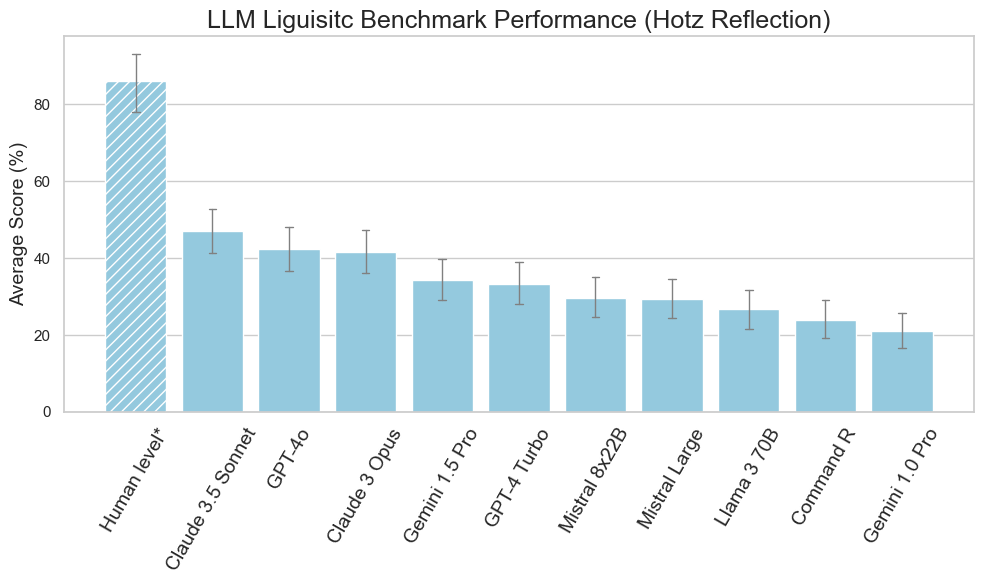

-- DONE STATS --



In [33]:
# Load in benchmark questions
if multiple_choice_questions:
    benchmark_questions = json.load(open('linguistic_benchmark_multi_choice.json', 'r'))
    sub_eval_folders = ['']
    def answer_validation_func(x):
        return validation_func(x, json_key='ANSWER', list_of_values=['A', 'B', 'C', 'D'])
else:
    benchmark_questions = json.load(open('linguistic_benchmark.json', 'r'))
    sub_eval_folders = [f'/round_{r+1}' for r in range(auto_eval_rounds)]
sub_answer_folders = [f'/round_{r+1}' for r in range(answer_rounds)]


if "get_llm_answers" in execution_steps:
    print('1. GETTING LLM ANSWERS')
    # Load in any existing answers and evals to avoid overwriting them
    for n in range(answer_rounds):
        print(f'\n----- Round: {n+1} of {answer_rounds} -----')
        answer_save_path_round = f"{answers_save_path}/round_{n+1}"
        all_llm_answers = load_all_llm_answers_from_json(answer_save_path_round,
            prefix_replace='final_answers-')
        print(f'Skipping existing LLM answers (in {date_now} folder):', list(all_llm_answers.keys()))
        answer_models_run = [model for model in answer_models 
                            if model_clean(model) not in all_llm_answers.keys()]
        if multiple_choice_questions:
            for q in benchmark_questions:
                prompt, correct_letter = construct_multiple_choice_question(q)
                q.update({'multi_choice_question': prompt, 'correct_letter': correct_letter})
        questions = {m: benchmark_questions for m in answer_models_run}
        all_llm_answers = await get_llm_answers(
            litellm_service(),
            benchmark_questions,
            answer_models_run,
            answer_hyperparams,
            answer_save_path_round,
            multiple_choice_questions,
            validation_func=answer_validation_func if multiple_choice_questions else lambda x: True
        )
    print('-- DONE ANSWERS --\n')


if "hotz_reflection" in execution_steps:
    print('1.5 GETTING HOTZ REFLECTION ANSWERS')
    # Load in any existing answers and evals to avoid overwriting them
    for n in range(answer_rounds):
        print(f'\n----- Round: {n+1} of {answer_rounds} -----')
        answer_save_path_round = f"{answers_save_path}/round_{n+1}"
        answer_hotz_save_path_round = f"{answers_hotz_save_path}/round_{n+1}"
        all_llm_answers = load_all_llm_answers_from_json(answer_save_path_round,
            prefix_replace='final_answers-')
        all_hotz_llm_answers = load_all_llm_answers_from_json(answer_hotz_save_path_round,
            prefix_replace='final_answers-')
        print(f'Skipping existing LLM answers (in {date_now} folder):', list(all_hotz_llm_answers.keys()))
        answer_models_run = [model for model in answer_models 
                            if model_clean(model) not in all_hotz_llm_answers.keys()]
        all_llm_questions = {model: info.to_dict('records') for model, info in all_llm_answers.items()}
        if multiple_choice_questions:
            for model, questions in all_llm_questions.items():
                for q in questions:
                    prompt = construct_hotz_reflection_question(q)
                    q.update({'multi_choice_question_pre': q['multi_choice_question']})
                    q.update({'model_answer_pre': q['model_answer']})
                    q.update({"json_answer_pre": q['json_answer']}),
                    q.update({"json_answer_letter_pre": q['json_answer_letter']}),
                    q.update({"invalid_answer_letter_pre": q['invalid_answer_letter']}),
                    q.update({'multi_choice_question': prompt})

        all_llm_answers = await get_llm_answers(
            litellm_service(),
            all_llm_questions,
            answer_models_run,
            answer_hyperparams,
            answer_hotz_save_path_round,
            multiple_choice_questions,
            validation_func=answer_validation_func if multiple_choice_questions else lambda x: True
        )
    print('-- DONE ANSWERS --\n')


if "auto_evaluate_answers" in execution_steps:
    print('2. AUTO EVALUATING ANSWERS')
    all_llm_answers = load_all_llm_answers_from_json(answers_save_path,
        prefix_replace='final_answers-', sub_folders=sub_answer_folders)
    if multiple_choice_questions:
        incomplete_llm_answers = calc_incomplete_llm_answers(all_llm_answers, auto_eval_save_path,
                                                             sub_eval_folders, date_now)
        all_llm_evals = score_multiple_choice_answers(incomplete_llm_answers, auto_eval_save_path)
        if hotz_reflection:
            print('\nEvaluate Hotz Reflections')
            all_llm_answers = load_all_llm_answers_from_json(answers_hotz_save_path,
                prefix_replace='final_answers-', sub_folders=sub_answer_folders)
            incomplete_llm_answers = calc_incomplete_llm_answers(all_llm_answers, auto_eval_hotz_save_path,
                                                                sub_eval_folders, date_now)
            all_llm_evals = score_multiple_choice_answers(incomplete_llm_answers, auto_eval_hotz_save_path)
    else:
        all_llm_eval_messages = create_all_llm_eval_messages(all_llm_answers, benchmark_questions)
        for n in range(auto_eval_rounds):
            print(f'- Round: {n+1} of {auto_eval_rounds} -')
            incomplete_llm_answers = calc_incomplete_llm_answers(all_llm_eval_messages, auto_eval_save_path,
                                                                 [f'/round_{n+1}'], date_now)
            all_llm_eval_responses = await get_llm_eval_responses(
                custom_llm_service(), 
                incomplete_llm_answers,
                model=auto_eval_model, 
                hyperparams=auto_eval_hyperparams,
                validation_func=lambda x: validation_func(x, json_key='score', 
                    list_of_values=[0, 20, 40, 60, 80, 100])
            )
            all_llm_scores = extract_all_scores(all_llm_eval_responses)
            auto_eval_save_path_n = f"{auto_eval_save_path}/round_{n+1}"
            all_auto_results = create_auto_eval_json(
                all_llm_scores, 
                all_llm_eval_responses, 
                all_llm_answers, 
                benchmark_questions, 
                auto_eval_save_path_n
            )
    print('-- DONE AUTO EVAL --\n')


if "generate_statistics" in execution_steps:
    print('3. GENERATING STATISTICS')
    all_stats_dfs = {}
    save_info = [{
        'path': auto_eval_save_path, 
        'chart_title': 'LLM Liguisitc Benchmark Performance'
    }]
    if hotz_reflection:
        save_info.append({
            'path': auto_eval_hotz_save_path, 
            'chart_title': 'LLM Liguisitc Benchmark Performance (Hotz Reflection)'
        })
    for info in save_info:
        save_path = info['path']
        chart_title = info['chart_title']
        print('Eval for path:', save_path)
        all_llm_evals = load_all_llm_answers_from_json(
            save_path, 
            prefix_replace='auto_eval-',
            sub_folders=sub_eval_folders,
        )
        stats_df = get_llm_stats(all_llm_evals, stats_save_path, bootstrap_n=10000)
        if multiple_choice_questions:
            for model, evals_df in all_llm_evals.items():
                #evals_df['invalid_answer_letter'] = evals_df.apply(lambda x: x['json_answer_letter'] not in ['A', 'B', 'C', 'D'], axis=1)
                incorrect_letter_count = evals_df['invalid_answer_letter'].sum()
                print(model, incorrect_letter_count)
                stats_df.loc[model, 'invalid_outputs'] = incorrect_letter_count

        display(stats_df)
        barplot, plt = create_performance_chart(stats_df.reset_index(), chart_title)
        barplot.figure.savefig(f"{stats_save_path}/performance_chart.png")
        plt.show()
        all_stats_dfs[chart_title] = stats_df
    print('-- DONE STATS --\n')

In [39]:
all_llm_evals = load_all_llm_answers_from_json(
    auto_eval_hotz_save_path, 
    prefix_replace='auto_eval-',
    sub_folders=sub_eval_folders,
)
all_llm_evals['claude-3-5-sonnet-20240620']
all_llm_evals['json_answer_pre'] = extract_valid_json(str(answer_row['model_answer']))


,level_0,index,category,question,human_answer,correct_answer,multiple_choice,multi_choice_question,correct_letter,model_answer,score,multi_choice_question_pre,model_answer_pre,json_answer,json_answer_letter,invalid_answer_letter
0,0,0,Puzzle,You have six horses and want to race them to s...,Race them on a single race track with at least...,One,"[One, Three, Unknown, Two]",\nQUESTION\n You have six horses and want t...,A,After carefully reviewing the question and my ...,0,QUESTION\n You have six horses and want to ...,Let's think through this step-by-step:\n\n1. W...,{'ANSWER': 'D'},D,0
1,1,1,Puzzle,"Suppose you're on a game show, and you're give...",It is not an advantage to switch. It makes no ...,They have equal probability of winning,"[Door No.3, They have equal probability of win...","\nQUESTION\n Suppose you're on a game show,...",B,After carefully reviewing the question and my ...,100,"QUESTION\n Suppose you're on a game show, a...","To answer this question, let's think through t...",{'ANSWER': 'B'},B,0
2,2,2,Spatial,You are playing Russian roulette with a six-sh...,"Yes, you should spin again. There was only one...","Yes, you should spin again",[It makes no difference if you spin again or n...,\nQUESTION\n You are playing Russian roulet...,B,After carefully reviewing the question and my ...,100,QUESTION\n You are playing Russian roulette...,Let's think through this step-by-step:\n\n1. I...,{'ANSWER': 'B'},B,0
3,3,3,Puzzle,A farmer wants to cross a river and take with ...,"Place the wolf, goat, and cabbage in separate ...",One crossing,"[Five crossings, One crossing, Seven crossings...",\nQUESTION\n A farmer wants to cross a rive...,B,"After carefully reviewing the question, I real...",100,QUESTION\n A farmer wants to cross a river ...,Let's think through this step-by-step:\n\n1. T...,{'ANSWER': 'B'},B,0
4,4,4,Puzzle,"Bob has three boxes in front of him - Box A, B...",Bob should not open a box because he has a 1/3...,"No, Bob should not open any box","[Yes, Box B, Yes, Box A, No, Bob should not op...",\nQUESTION\n Bob has three boxes in front o...,C,After carefully reviewing the question and my ...,100,QUESTION\n Bob has three boxes in front of ...,"To answer this question, let's consider the in...",{'ANSWER': 'C'},C,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,25,Puzzle,A runaway trolley is heading down the tracks a...,"It doesn't impact anyones lives, as the trolle...",It doesn't impact their lives.,"[Pulling the lever will take their lives., Pul...",\nQUESTION\n A runaway trolley is heading d...,C,"After carefully reviewing the question, I real...",0,QUESTION\n A runaway trolley is heading dow...,I'll analyze this question and provide my reas...,{'ANSWER': 'D'},D,0
296,296,26,Puzzle,How do you efficiently measure exactly 4 gallo...,Fill up the 4-gallon jug,Another option not stated.,"[Filling the 2-gallon jug, twice., Another opt...",\nQUESTION\n How do you efficiently measure...,B,"After carefully reviewing the question, I real...",0,QUESTION\n How do you efficiently measure e...,"To answer this question, let's think through t...",{'ANSWER': 'A'},A,0
297,297,27,Popular science,A 2kg tree grows in a planted pot with 10kg of...,There is still 10kg of soil. Trees are primari...,10kg,"[11kg, 9kg, 8kg, 10kg]",\nQUESTION\n A 2kg tree grows in a planted ...,D,After carefully reviewing the question and my ...,0,QUESTION\n A 2kg tree grows in a planted po...,Let's think through this step-by-step:\n\n1. I...,{'ANSWER': 'B'},B,0
298,298,28,Relational,A man steps over a 0.5m hurdle. What is the mi...,"0m, he didn't jump at all, he stepped over the...",0m,"[0m, 0.5m, Between 0.1m and 0.5m, Slightly hig...",\nQUESTION\n A man steps over a 0.5m hurdle...,A,After carefully reviewing the question and my ...,0,QUESTION\n A man steps over a 0.5m hurdle. ...,"To answer this question, let's think through t...",{'ANSWER': 'D'},D,0


In [34]:
all_stats_dfs['LLM Liguisitc Benchmark Performance (Hotz Reflection)'] - all_stats_dfs['LLM Liguisitc Benchmark Performance']

,mean_score,std_dev_score,z_interval_error,ci_lower,ci_upper,output_count,invalid_outputs
model,,,,,,,
claude-3-5-sonnet-20240620,-2.666667,-0.089119,-0.010085,-2.666667,-2.666667,0.0,1.0
claude-3-opus-20240229,-1.333333,-0.207256,-0.023453,-1.333333,-1.333333,0.0,0.0
command-r,-1.000000,-0.593948,-0.067212,-1.000000,-1.000000,0.0,1.0
gemini-1_0-pro,-0.333333,-0.235680,-0.026670,0.000000,-0.333333,0.0,-2.0
gemini-1_5-pro,3.000000,1.099130,0.124378,2.666667,3.000000,0.0,-6.0
gpt-4-turbo-preview,-1.666667,-0.557438,-0.063080,-1.666667,-1.333333,0.0,0.0
gpt-4o,-1.666667,-0.230353,-0.026067,-1.666667,-1.666667,0.0,0.0
meta_llama3-70b-instruct-v1_0,-2.666667,-1.309510,-0.148185,-2.666667,-3.000000,0.0,-2.0
mistral-large-latest,0.666667,0.309057,0.034973,0.666667,1.000000,0.0,-2.0


In [26]:
raise

RuntimeError: No active exception to reraise

In [ ]:
answers = all_llm_evals['gpt-4-turbo-preview'][['question', 'model_answer', 'json_answer', 'correct_letter', 'score']]
for row in answers.to_dict('records'):
    print('--------------')
    print('\nQuestion\n', row['question'])
    print('\nModel Answer\n', row['model_answer'])
    print('\nJson Answer\n', row['json_answer'])
    print('\nCorrect Letter\n', row['correct_letter'])    
    print('\nScore\n', row['score'])

--------------

Question
 You have six horses and want to race them to see which is fastest. What is the minimum number of races needed to do this?

Model Answer
 To determine the minimum number of races needed to find the fastest horse out of six, without any additional conditions such as the number of horses that can race at a time being specified, we need to consider the most efficient way to rank them. If we assume that only five horses can race at a time (a common assumption for this type of problem due to track limitations), the solution would unfold as follows:

1. Race all six horses in groups of five to get a sense of their relative speeds within each group. This would take one race for each group, totaling 5 races (but since we have only six horses, we adjust this to fit our scenario). We would need at least one race to see five of them in action. After the first race, we have some information but not complete.

2. We cannot determine the fastest horse in just one race unless

# Inspect Auto Eval Consistancy

In [ ]:
all_llm_evals = load_all_llm_answers_from_json(
    auto_eval_save_path, 
    prefix_replace='auto_eval-',
    sub_folders=sub_eval_folders,
)
models = list(all_llm_evals.keys())


model = models[3]
print(f"Model: {model}")
auto_eval_agg = all_llm_evals[model].set_index('level_0').groupby('index').agg({'score': ['mean', 'min', 'max']})
auto_eval_agg.index.name = 'Question #'
auto_eval_agg

Model: gemini-1_0-pro


score          
             mean  min  max
Question #                 
1             0.0    0    0
2             0.0    0    0
3            20.0    0  100
4             0.0    0    0
5            80.0    0  100
6            60.0    0  100
7            30.0    0  100
8            10.0    0  100
9             0.0    0    0
10           10.0    0  100
11           50.0    0  100
12           10.0    0  100
13           10.0    0  100
14            0.0    0    0
15            0.0    0    0
16          100.0  100  100
17            0.0    0    0
18           10.0    0  100
19            0.0    0    0
20           20.0    0  100
21           20.0    0  100
22           20.0    0  100
23           30.0    0  100
24            0.0    0    0
25           70.0    0  100
26            0.0    0    0
27            0.0    0    0
28           50.0    0  100
29           10.0    0  100
30           10.0    0  100

In [ ]:
# tables_folder = "2024-06-12-Multi-Benchmark (temp=1)/tables_and_charts"
# stats_df = pd.read_csv(f"{tables_folder}/final_stats.csv", index_col=0)
# barplot, plt = create_performance_chart(stats_df.reset_index())
# barplot.figure.savefig(f"{tables_folder}/performance_chart.png")